In [231]:
# This is a first simple GAN that learns to model a very simple distribution
# It is not a convolutional GAN

In [232]:
# Imports
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from tqdm import tqdm
import torch.nn.functional as F
from torch.nn.init import kaiming_uniform_
import io
import PIL.Image

from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import ToTensor

z_width = 5

In [233]:
# Helper function to save matplotlib plots to a buffer for drawing to tensorboard.

def gen_plot():
    buf = io.BytesIO()
    plt.savefig(buf, format='jpeg')
    buf.seek(0)
    return buf

In [234]:
# Create the distribution of the real data and a sampler
# The 'real data' is sampled from a 2 Dimensional Gaussian distribution

class GaussianDataset(Dataset):
    def __init__(self, mean, cov, N):
        self.data = np.random.multivariate_normal(mean, cov, N).astype(float)
        self.mean = mean
        self.cov = cov
        self.N = N
    
    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        return self.data[idx]

In [235]:
# Display contour lines for given distribution

def display_contours(mean, cov, mn_x, mx_x, mn_y, mx_y):
    x, y = np.mgrid[mn_x:mx_x:0.1, mn_y:mx_y:0.1]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    rv = multivariate_normal(mean, cov)
    plt.contourf(x, y, np.log(rv.pdf(pos)), cmap='Greys')

(-10, 10)

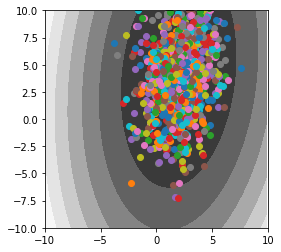

In [236]:
# Test the creation of the dataset

real_mean = [2, 4]
real_cov = [[3, 1], [1, 12]]
dataset = GaussianDataset(mean=real_mean, cov=real_cov, N=1000)


plt.figure(figsize=(4, 4))
display_contours(real_mean, real_cov, -10, 10, -10, 10)
for i, datum in enumerate(dataset):
    plt.scatter(datum[0], datum[1])
    
plt.xlim(-10, 10)
plt.ylim(-10, 10)

In [237]:
# Generator Network
class Generator(torch.nn.Module):
    def __init__(self, z_width = 5):
        super().__init__()
        self.lin1 = torch.nn.Linear(z_width, 15)
        self.lin2 = torch.nn.Linear(15, 2)
        kaiming_uniform_(self.lin1.weight, nonlinearity='relu')
        kaiming_uniform_(self.lin2.weight, nonlinearity='relu')
        
    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        
        return x

In [238]:
# Discriminator Network
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = torch.nn.Linear(2, 25)
        self.lin2 = torch.nn.Linear(25, 1)
        kaiming_uniform_(self.lin1.weight, nonlinearity='relu')
        kaiming_uniform_(self.lin2.weight, nonlinearity='relu')
        
    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

/home/skusku/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/home/skusku/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


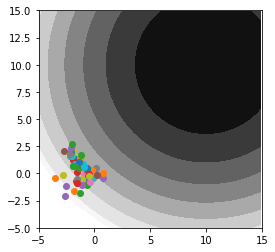

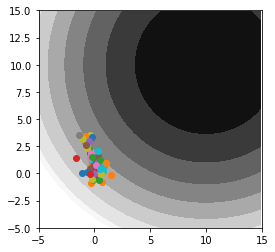

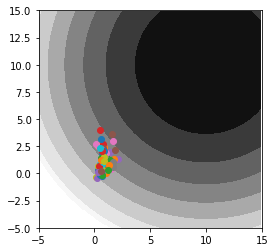

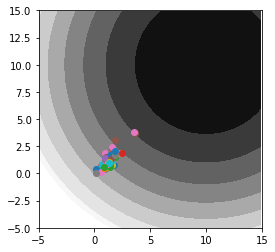

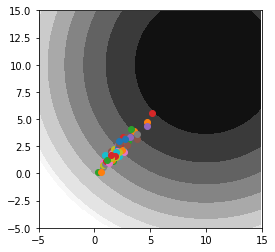

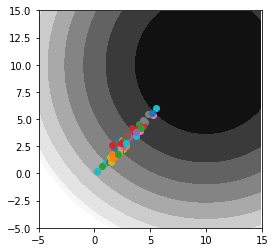

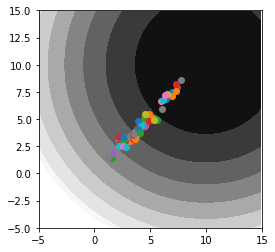

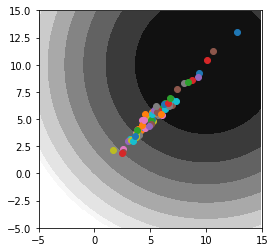

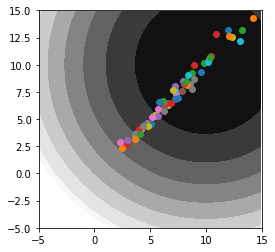

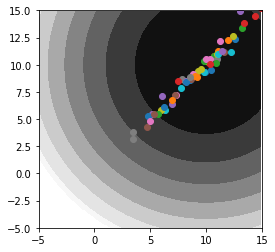

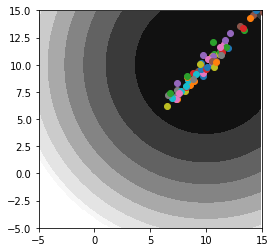

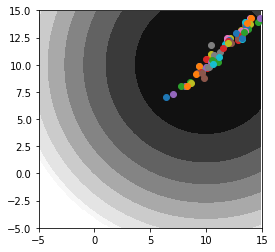

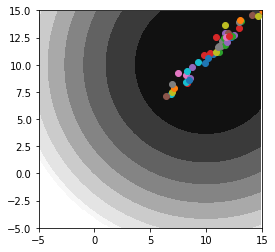

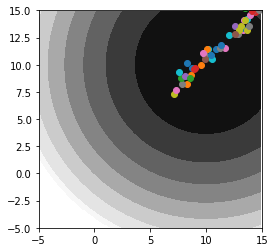

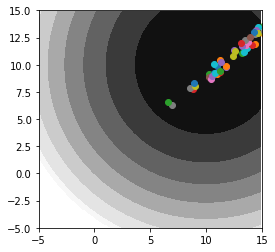

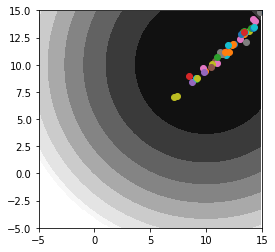

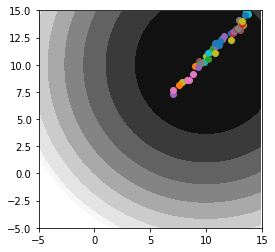

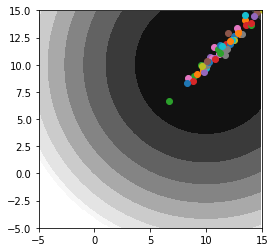

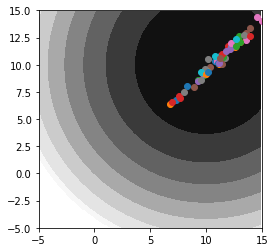

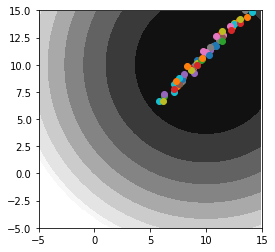

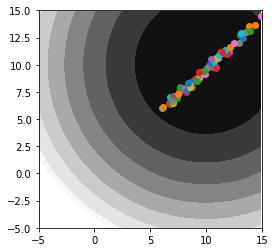

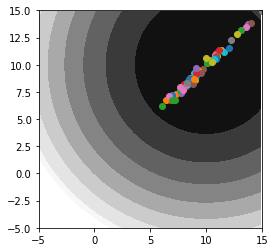

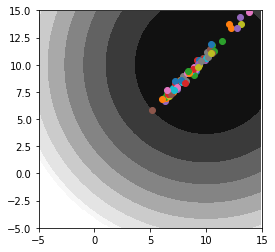

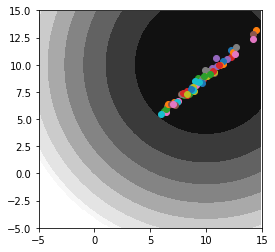

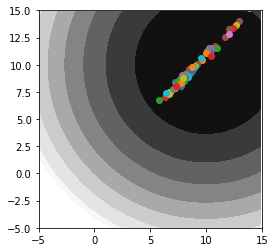

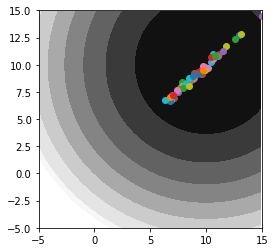

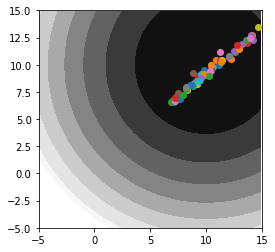

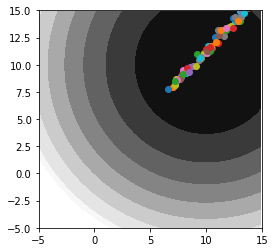

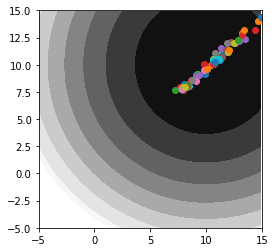

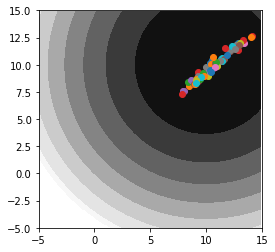

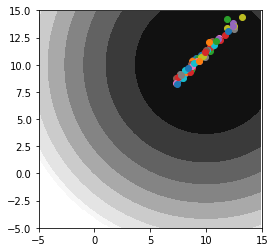

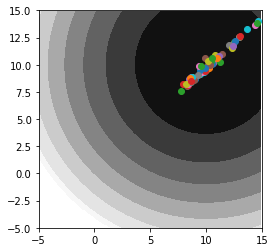

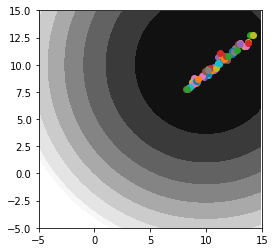

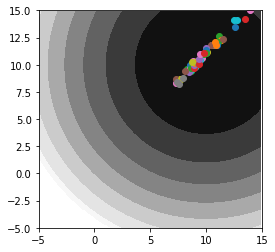

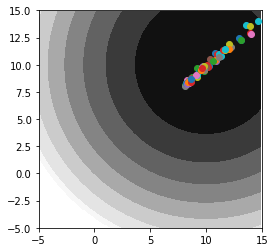

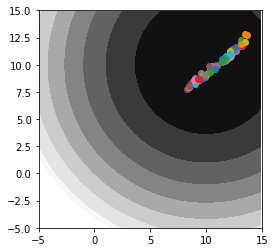

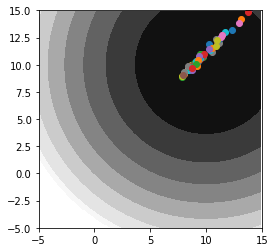

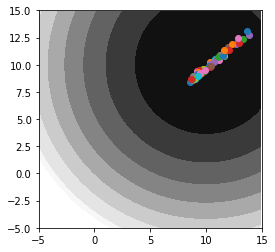

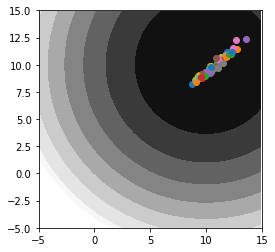

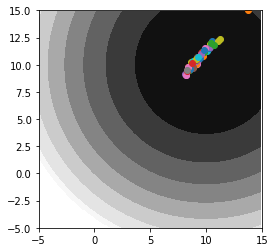

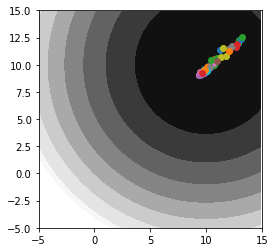

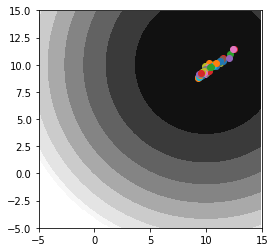

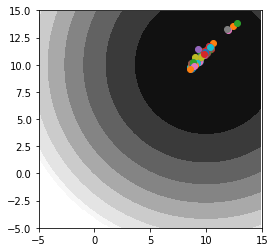

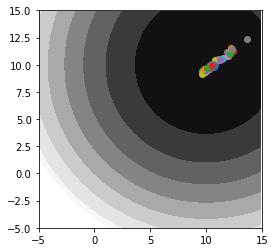

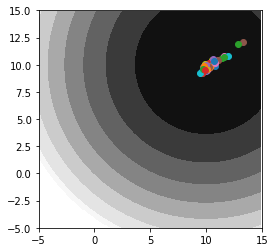

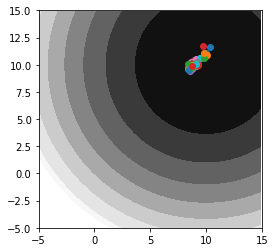

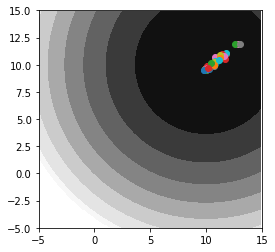

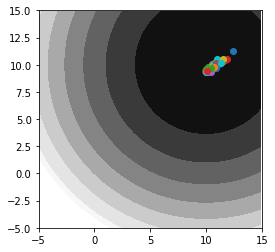

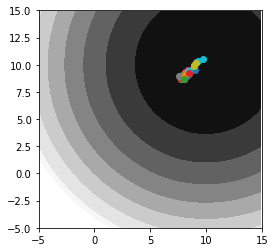

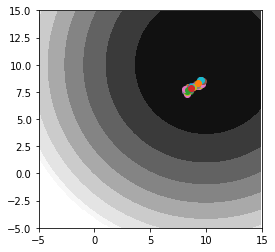

In [239]:
# Training
writer = SummaryWriter()

# Create the 'real data' dataset
real_mean = [10, 10]
real_cov = [[0.2, 0], [0, 0.2]]
real_dataset = GaussianDataset(mean=real_mean, cov=real_cov, N=1000)
real_dataloader = DataLoader(real_dataset, batch_size=64, shuffle=True, num_workers=1)

epochs = 5000
batch_size = 64

# Create the models
disc = Discriminator()
D_optimizer = torch.optim.Adam(disc.parameters())

gen = Generator()
G_optimizer = torch.optim.Adam(gen.parameters())

disc.train()
gen.train()

# Binary Cross Entropy Loss
criterion = torch.nn.BCEWithLogitsLoss()

for i in range(epochs):
    # Sample from the 'real data'
    X_real = next(iter(real_dataloader)).type(torch.FloatTensor)
       
    # Train generator
    G_optimizer.zero_grad()
        # Sample from the latent space
    z = torch.randn((batch_size, z_width))
    gen_opt = gen(z)
        # The generator wants to generate outputs that the discriminator thinks are 'real'
        # Thus our targets are ones, suggesting 'real' data
    y = torch.ones((batch_size, 1), dtype=torch.float32)
        # The loss is then computed through the discriminator and the generator.
    g_loss = criterion(disc(gen_opt), y)
    g_loss.backward()
    G_optimizer.step()
    
    if i % 100 == 0:
        figure = plt.figure(figsize=(4, 4))
        display_contours(real_mean, real_cov, -5, 15, -5, 15)
        for i, datum in enumerate(gen_opt):
            x = datum.detach().numpy()
            plt.scatter(x[0], x[1])

        plt.xlim(-5, 15)
        plt.ylim(-5, 15)

        plot_buf = gen_plot()
        image = PIL.Image.open(plot_buf)
        image = ToTensor()(image)
        writer.add_image('Generated Data', image, i)
    
    # Train discriminator
    D_optimizer.zero_grad()
        # Here the ys for 'real' data are ones
    y = torch.ones((batch_size, 1), dtype=torch.float32)
    real_loss = criterion(disc(X_real), y)
    
        # And the ys for 'fake' data are zeros
    y = torch.zeros((batch_size, 1), dtype=torch.float32)
    fake_loss = criterion(disc(gen_opt.detach()), y)
    
        # The loss is just the mean of the two losses
    d_loss = (real_loss + fake_loss) / 2
    d_loss.backward()
    D_optimizer.step()
    
              
writer.close()